### Dataset Download

In [26]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/intel-image-classification.zip -d /content/

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from keras.models import Sequential
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten,
                          MaxPooling2D,GlobalAveragePooling2D)

from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam,Adamax
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [4]:
train = "/content/seg_train/seg_train"
test = "/content/seg_test/seg_test/"

## data loading and augmentation

In [5]:
IMG_WIDTH = 160
IMG_HEIGHT = 160
BATCH_SIZE = 32

train_datagen= ImageDataGenerator(rescale=1.0/255,zoom_range=0.2,width_shift_range=0.2,
                               validation_split=0.25,height_shift_range=0.2,fill_mode="nearest")

train_ds = train_datagen.flow_from_directory(train, target_size=(IMG_WIDTH,IMG_HEIGHT),
                             subset='training', batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True)

validation_ds= train_datagen.flow_from_directory(train,target_size=(IMG_HEIGHT,IMG_WIDTH),
                               subset='validation', batch_size=BATCH_SIZE, class_mode="categorical",shuffle=True)

test_datagen = ImageDataGenerator(rescale= 1.0/255)

test_ds= test_datagen.flow_from_directory(test,target_size=(IMG_HEIGHT,IMG_WIDTH),
                                       batch_size=BATCH_SIZE, class_mode="categorical",shuffle=True)

Found 10528 images belonging to 6 classes.
Found 3506 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [6]:
for key, value in train_ds.class_indices.items():
    print(f"{key} : {value}")


buildings : 0
forest : 1
glacier : 2
mountain : 3
sea : 4
street : 5


### Plotting some images

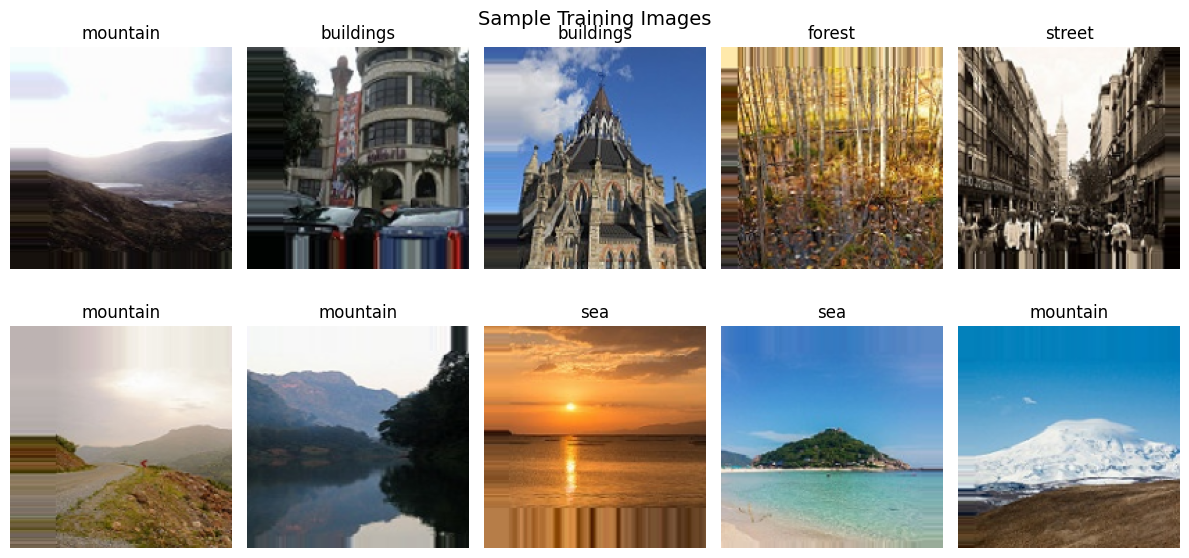

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
idx = 0
labels = {value: key for key, value in train_ds.class_indices.items()}
for i in range(2):
    for j in range(5):
        lable = labels[np.argmax(train_ds[0][1][idx])]
        ax[i,j].set_title(f"{lable}")
        ax[i, j].imshow(train_ds[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=14)
plt.show()

### **Simple CNN**

In [ ]:
def create_model():
  model = Sequential([
    Conv2D(128, (5, 5), padding="valid", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),Activation('relu'),
    MaxPooling2D((2, 2)), BatchNormalization(),

    Conv2D(64,(3, 3), padding="valid", kernel_regularizer=l2(0.00005)), Activation('relu'),
    MaxPooling2D((2, 2)), BatchNormalization(),

    Conv2D(32, (5, 5), padding="valid", kernel_regularizer=l2(0.00005)),  # Fixed missing parenthesis
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)), BatchNormalization(),

    Flatten(),

    Dense(128, activation="relu"), Dropout(0.5),
    Dense(6, activation="softmax")
  ])
  return model

In [ ]:
cnn_model = create_model()
cnn_model.summary()

In [ ]:
from keras.models import load_model
model = load_model('/content/intel1.keras')

### **RESNET52**

In [18]:
from keras.applications import VGG16, ResNet50V2
input_shape = (160, 160, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

res_model = Sequential([base_model,BatchNormalization(),GlobalAveragePooling2D(),
                    Dense(512, activation='relu'),Dropout(0.1),
                    Dense(256, activation='relu'), Dropout(0.2),
                    Dense(128, activation='relu'),Dropout(0.1),
                    Dense(6, activation='softmax')
                  ])
opti = Adamax(learning_rate=0.0001)
res_model.compile(optimizer=opti, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
tf.keras.utils.plot_model(res_model, show_shapes=True, show_layer_names=True, show_layer_activations=True)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss=categorical_crossentropy,
                  metrics=['accuracy'])

In [20]:
tr_steps = train_ds.samples // train_ds.batch_size + 1
validation_steps = validation_ds.samples // validation_ds.batch_size + 1
tr_steps,validation_steps

(330, 110)

In [23]:
es = EarlyStopping(monitor='val_loss', patience = 7, min_delta=0.001,verbose=1, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [25]:
his = res_model.fit(train_ds, steps_per_epoch = 320, epochs=3,validation_data=validation_ds,
                    validation_steps = 100, callbacks=[es])

Epoch 1/30
320/320 [==============================] - 178s 447ms/step - loss: 0.8537 - accuracy: 0.7183 - val_loss: 0.3261 - val_accuracy: 0.8863
Epoch 2/30
320/320 [==============================] - 141s 442ms/step - loss: 0.3750 - accuracy: 0.8757 - val_loss: 0.2858 - val_accuracy: 0.9009
Epoch 3/30
320/320 [==============================] - 140s 438ms/step - loss: 0.2966 - accuracy: 0.9019 - val_loss: 0.2650 - val_accuracy: 0.9097
Epoch 4/30
320/320 [==============================] - 140s 437ms/step - loss: 0.2493 - accuracy: 0.9166 - val_loss: 0.2430 - val_accuracy: 0.9181
Epoch 5/30
320/320 [==============================] - 140s 437ms/step - loss: 0.2180 - accuracy: 0.9254 - val_loss: 0.2426 - val_accuracy: 0.9184
Epoch 6/30
320/320 [==============================] - 140s 437ms/step - loss: 0.1973 - accuracy: 0.9303 - val_loss: 0.2423 - val_accuracy: 0.9166
Epoch 7/30
320/320 [==============================] - 135s 423ms/step - loss: 0.1819 - accuracy: 0.9362 - val_loss: 0.2467 -

In [ ]:
model.save('intel_resnet.keras')

In [27]:
train_accuracy = his.history['accuracy']
val_accuracy = his.history['val_accuracy']

train_loss = his.history['loss']
val_loss = his.history['val_loss']

# learning_rate = his.history['learning_rate']

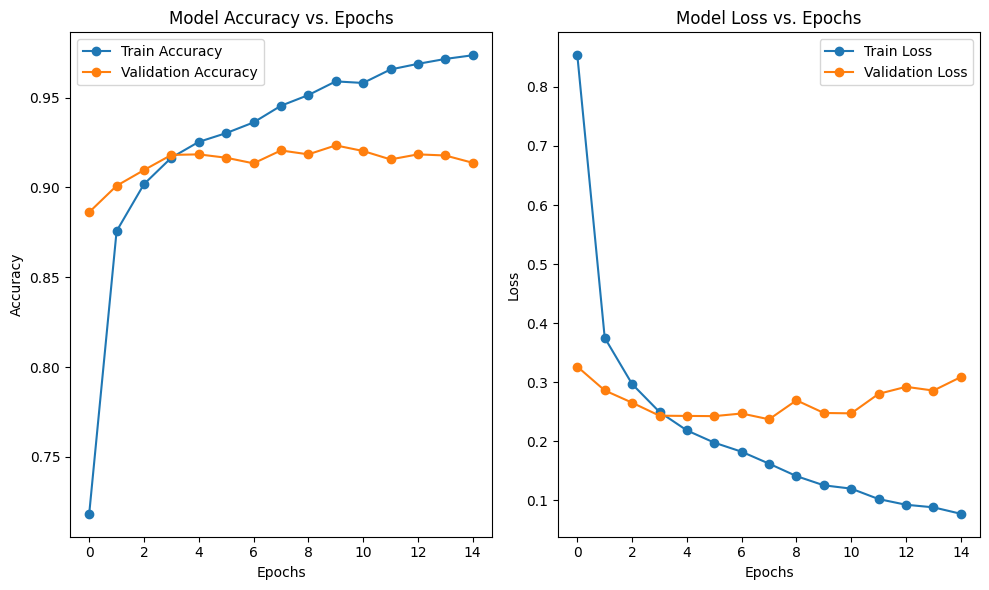

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

ax[0].set_title('Model Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Model Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [32]:
loss,acc=res_model.evaluate(test_ds)
print('Test loss: {:.3f}'.format(loss))
print('Test accuracy: {:.3f}'.format(acc))

94/94 [==============================] - 6s 61ms/step - loss: 0.2310 - accuracy: 0.9223
Test loss: 0.231
Test accuracy: 0.922


## Predicting a single image

In [46]:
from keras.preprocessing import image
class_map = dict([value, key] for key, value in train_ds.class_indices.items())

def prediction(testing_image, actual_label):
    # Load & Preprocess the Image
    test_img = image.load_img(testing_image, target_size = (160,160))
    test_img_arr = image.img_to_array(test_img) / 255
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0],
                                          test_img_arr.shape[1],
                                          test_img_arr.shape[2]))

    # Make Prediction
    predicted_class = np.argmax(res_model.predict(test_img_input))
    predicted_img = class_map[predicted_class]

    # Visulize the Image
    plt.figure(figsize = (4,4))
    plt.imshow(test_img_arr)
    plt.title("Acutal Label : {}, Predicted Label : {}".format(actual_label, predicted_img))
    plt.grid()
    plt.axis("off")


In [47]:
import os
import random

def choose_random_file(directory):
  files = os.listdir(directory)

  # Choose a random file from the list
  random_file = random.choice(files)

  # Return the path to the chosen file
  return os.path.join(directory, random_file)

In [50]:
directory = "/content/seg_test/seg_test/buildings"
random_file_path = choose_random_file(directory)

1/1 [==============================] - 0s 33ms/step


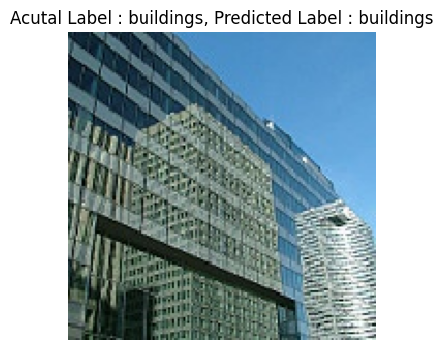

In [51]:
img = random_file_path
prediction(img, actual_label = "buildings")

### Predicting 10 images

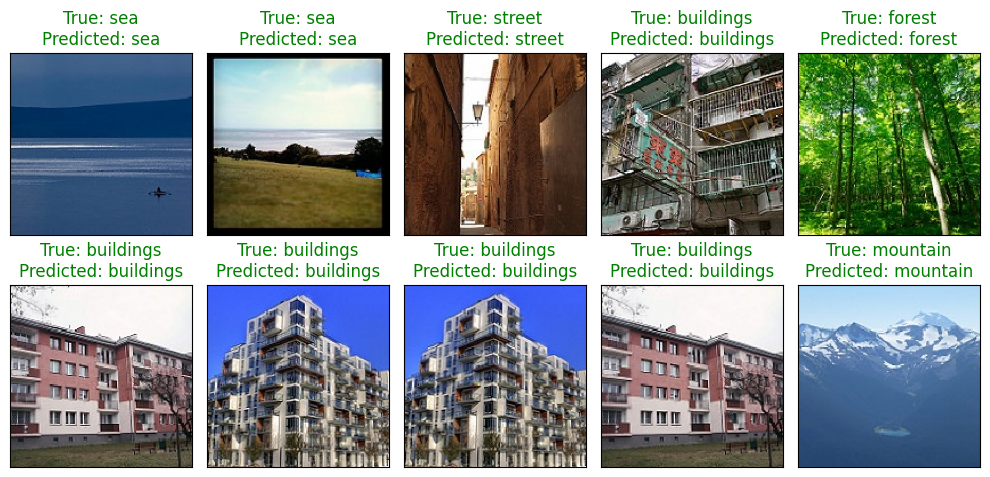

In [54]:
#  classes for the dataset
class_map = dict([value, key] for key, value in train_ds.class_indices.items())

# Assuming test_generator and model are already defined
batch_size = test_ds.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_ds) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_ds[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_ds[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(res_model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0),axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if class_map[Random_Img_Label] == class_map[Model_Prediction] else "red"
    ax.set_title(f"True: {class_map[Random_Img_Label]}\nPredicted: {class_map[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()